# <u> Salary prediction with tree-based models </u>

# 0. Introduction

For my masterthesis I developed tree-based models for salary prediction. 
I worked on a public dataset from  [Kaggle](https://www.kaggle.com/datasets/rhuebner/human-resources-data-set?select=HRDataset_v14.csv), containing information about a fictitious company. 
This Project was my first hands-on experience with python and machine learning.


The thesis was awarded with a score of 16/20. A more condensed version will be presented here.
We will discuss:
- Data cleaning
- Exploratory analysis
- Modelling


In [1]:
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# 1. Get the data

In [2]:
data_path = os.path.abspath('HRdataset_v14.csv')
dataset = pd.read_csv(data_path)

In [3]:
dataset.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2


In [4]:
# select the columns that will be used in the analysis
columns = ['FromDiversityJobFairID', 'Salary', 'Position', 'State', 'DOB', 'Sex', 'MaritalDesc', 'CitizenDesc',
            'EmploymentStatus', 'Department', 'ManagerName', 'RecruitmentSource', 'PerformanceScore',
            'EngagementSurvey', 'EmpSatisfaction', 'SpecialProjectsCount', 'DaysLateLast30', 'Absences','DateofHire',
          'DateofTermination']
dataset = dataset[columns]

In [5]:
# check for missing values
dataset.isnull().sum()

FromDiversityJobFairID      0
Salary                      0
Position                    0
State                       0
DOB                         0
Sex                         0
MaritalDesc                 0
CitizenDesc                 0
EmploymentStatus            0
Department                  0
ManagerName                 0
RecruitmentSource           0
PerformanceScore            0
EngagementSurvey            0
EmpSatisfaction             0
SpecialProjectsCount        0
DaysLateLast30              0
Absences                    0
DateofHire                  0
DateofTermination         207
dtype: int64

207 people have no termination date, meaning they are still employed by the company

# 2. Data cleaning

Data needs to be cleaned before we can train our machine learning models.
- We will remove people from the upper management as their salary may not be comparable to others
- we will rename variables to make them more readable
- we will generate new features and transform others to dummys

In [6]:
# remove the persons with the highest salaries from the dataset
# these are a limited cases that have very high salaries
dataset = dataset[dataset['Position'].str.contains(
    'President & CEO|CIO|Director of Sales|IT Director|Director of Operations|IT Manager|Data Architect|BI Director')
       == False]

## 2.1. Renaming features

In [7]:
dataset.rename(columns={'FromDiversityJobFairID': 'FromDiversityJobFair', 'EngagementSurvey': 'EngagementScore'},
               inplace = True)

In [8]:
dataset['Sex'] = dataset['Sex'].replace('M ','Male')
dataset['Sex'] = dataset['Sex'].replace('F','Female')

In [9]:
dataset['Position'] = dataset['Position'].replace('Data Analyst ', 'Data Analyst')

In [10]:
dataset['Department'] = dataset['Department'].replace('Production       ', 'Production')

## 2.2. Feature engeneering

### 2.2.1. Constructing new variables

In [11]:
dataset["DOB"] = pd.to_datetime(dataset["DOB"])
dataset["Age"] = datetime.datetime.now().year - dataset["DOB"].dt.year

# the years that are in the form 'xx' are translated to '20XX' instead of '19XX' resulting in negative age
# add 100 if age is negative
dataset.loc[dataset["Age"] < 0, "Age"] = dataset["Age"] + 100
dataset = dataset.drop('DOB', axis = 1)

In [12]:
# compute the numer of years they are employed
# those with no termination date are expected to work up untill today
dataset['DateofHire'] = pd.to_datetime(dataset['DateofHire'])
dataset['DateofTermination'] = pd.to_datetime(dataset['DateofTermination'])
dataset['DateofTermination'] = dataset['DateofTermination'].fillna(datetime.datetime.now())
dataset['YearsInService'] = dataset['DateofTermination'].dt.year - dataset['DateofHire'].dt.year

dataset = dataset.drop('DateofTermination', axis = 1)

In [13]:
# compute the amount of years it has been since the person was hired
dataset['YearsSinceHire'] = datetime.datetime.now().year - dataset['DateofHire'].dt.year
dataset = dataset.drop('DateofHire', axis = 1)

### 2.2.2. Creating dummy-variables

In [14]:
dataset_dummy = pd.get_dummies(dataset, columns = ['Position', 'Sex', 'MaritalDesc', 'CitizenDesc','EmploymentStatus',
                                                   'Department', 'ManagerName', 'PerformanceScore'])

In [15]:
# create a dummy for the state variable
dataset_dummy['FromMassachusetts'] = np.where(dataset['State'].str.contains('MA'), 1, 0)
dataset_dummy.drop('State', axis = 1, inplace = True)

In [16]:
# create dummy if the person was recruited online
dataset_dummy['RecruitedOnline'] = np.where(dataset['RecruitmentSource'].str.contains(
    'LinkedIn|Indeed|Google Search|On-line Web application|CareerBuilder|Website'), 1, 0)
dataset_dummy.drop('RecruitmentSource', axis = 1, inplace = True)

In [17]:
dataset_dummy['SpecialProject'] = np.where(dataset['SpecialProjectsCount']>0, 1, 0)
dataset_dummy.drop('SpecialProjectsCount', axis = 1, inplace = True)

In [18]:
dataset_dummy['LateLast30']= np.where(dataset['DaysLateLast30']>0, 1, 0)
dataset_dummy.drop('DaysLateLast30', axis = 1, inplace = True)

# 3. Exploratory analysis

It is important to get an idea of the data we are working with.
we will look at:
- The shape of the dataset
- The distribution of salary
- the impact of some variables on salary

In [19]:
dataset_dummy.shape

(299, 75)

In [20]:
#een overzicht over de variabele 'Salary'
dataset['Salary'].describe()

count       299.000000
mean      65215.575251
std       14942.086798
min       45046.000000
25%       55070.000000
50%       62162.000000
75%       70327.500000
max      114800.000000
Name: Salary, dtype: float64

<AxesSubplot:xlabel='Salary', ylabel='Density'>

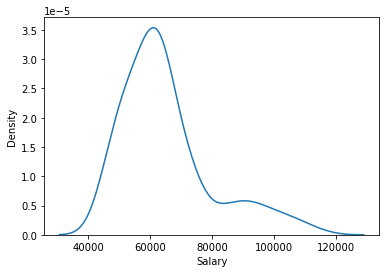

In [21]:
sns.kdeplot(data = dataset, x = 'Salary')

Text(0.5, 1.0, 'Salary of employees per Performance Score and sex')

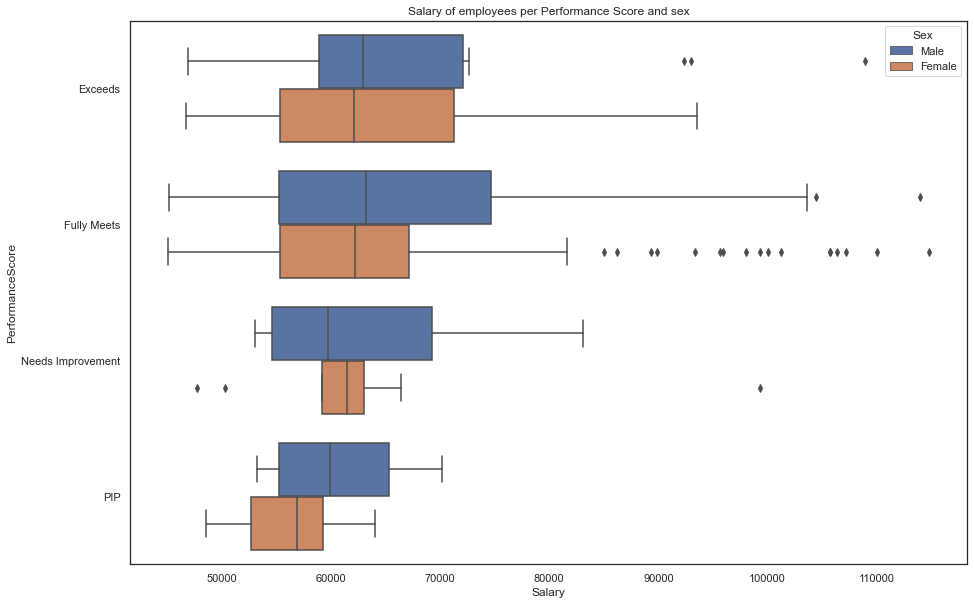

In [22]:
#boxplot for salary per performance and sex
plt.figure(figsize=(15,10))
sns.set_theme(style='white')
sns.boxplot(x=dataset['Salary'], y=dataset['PerformanceScore'], hue = dataset['Sex'])
plt.title('Salary of employees per Performance Score and sex')

- The female salaries are lower on average, except for the "needs inprovement" category
- Salaries within performance classes differ greatly
- lower performance is linked with lower pay, this seems especially the case for women

Text(0.5, 1.0, 'Regressieplot for Salary and Age')

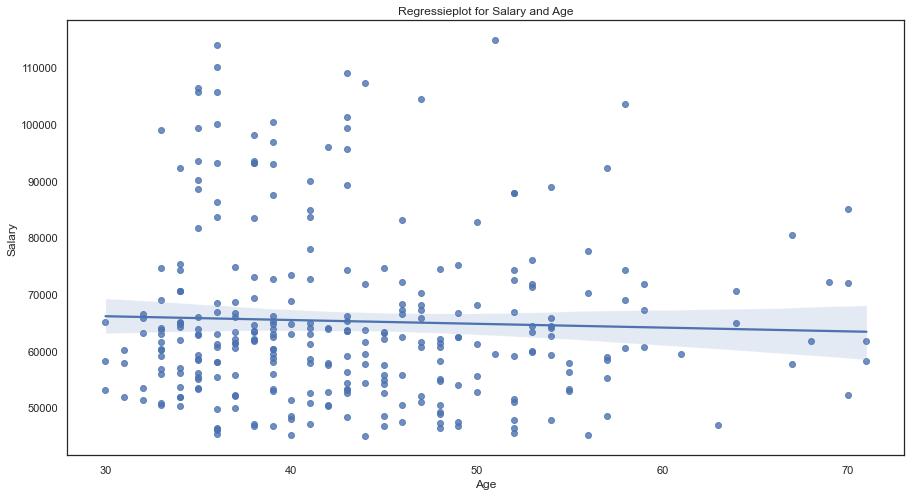

In [23]:
# regression plot for salary and age
plt.figure(figsize=(15,8))
sns.regplot(x=dataset['Age'], y=dataset['Salary'], color='b')
plt.title('Regressieplot for Salary and Age')

- Only a small effect of age on salary
- age is negatively correlated with salary

In [24]:
# select variables for correlation matrix
df_var= dataset_dummy[['Salary', 'FromDiversityJobFair', 'EngagementScore', 'EmpSatisfaction','LateLast30', 'Absences',
                       'Age', 'YearsSinceHire', 'YearsInService','FromMassachusetts', 'RecruitedOnline', 'SpecialProject']]

Text(0.5, 1.0, 'Correlation matrix')

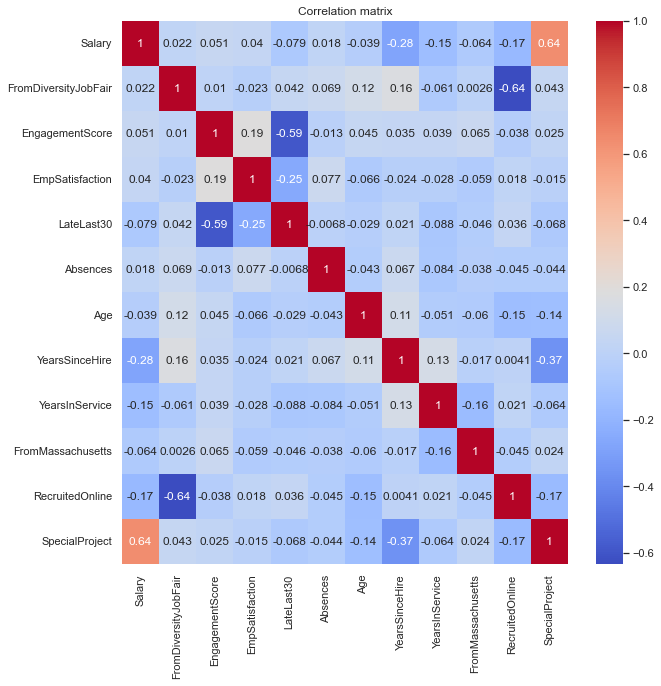

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(df_var.corr(), annot= True, cmap= 'coolwarm')
plt.title("Correlation matrix")

- SpecialProjects has the highest correlation out of the selected variables
- The people that were hired more recently tend to make more money
- Being recruited via online methodes tends to be linked to a lower Salary

# 4. Modelling

we are working with a small tabular dataset, that has a lot of features
Next to that our target variable is not normal distributed.
The effects of different features are not necessary linear

These facts make tree-based models well suited, since:
- They automaticly select the variables with the highest performance
- They do not make assumptions about the distribution of the target variable
- They can model non linear relationships

Since we already have a very small dataset it is not beneficial to so a train - development split. We decided to do hyperparametertuning on one random shuffle of the dataset. The models were evaluated afterwards using a 10X10 cross-validation on another random shuffle.

In [26]:
# get the different models that will be used
Tree = DecisionTreeRegressor()
Forest = RandomForestRegressor()
Booster = GradientBoostingRegressor()

In [27]:
# get the variables 
X = dataset_dummy.drop(['Salary'], axis=1)
y = dataset_dummy['Salary']

## 4.1. Parametertuning

### Desicion Tree

In [28]:
#hyperparameters for Tree Regression
criterion_tree = ['mse', 'mae']
max_depth_tree = [10, 15, 25, None]
min_samples_split_tree = [2, 5, 10, 20]
min_samples_leaf_tree = [1, 2, 5]
max_features_tree = ['log2', 'sqrt', 0.25, 1.0]

In [29]:
# construct arameter grid
param_grid_tree = {'criterion': criterion_tree,
                  'max_depth': max_depth_tree,
                  'min_samples_split': min_samples_split_tree,
                  'min_samples_leaf': min_samples_leaf_tree,
                  'max_features': max_features_tree}

In [30]:
# This implementation leads to an exhaustive search since the possible hyperparameter combinations are less than 1000
tree_random = RandomizedSearchCV(estimator = Tree, param_distributions = param_grid_tree,
                                 scoring = 'neg_root_mean_squared_error', n_iter = 1000, verbose = 2, n_jobs = -1,
                                 random_state = 1)
tree_random.fit(X, y)

C:\Users\32474\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 384 is smaller than n_iter=1000. Running 384 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 384 candidates, totalling 1920 fits


RandomizedSearchCV(estimator=DecisionTreeRegressor(), n_iter=1000, n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': [10, 15, 25, None],
                                        'max_features': ['log2', 'sqrt', 0.25,
                                                         1.0],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=1, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [31]:
tree_random.best_params_

{'min_samples_split': 20,
 'min_samples_leaf': 1,
 'max_features': 0.25,
 'max_depth': 25,
 'criterion': 'mae'}

### Random Forest

In [32]:
#hyperparameters for Random forest
#number of trees
n_estimators_rf= [50, 100, 150, 200]
#splittingrule
criterion_rf = ['mse', 'mae']
#max number of features to consider at every split
max_features_rf = ['auto', 'sqrt', 5]
#maximum number of levels in tree
max_depth_rf = [2, 5, 10, 15, None]
#minimum number of samples required to split a node
min_samples_split_rf = [2, 5, 10]
#minimum number of samples required at each leaf node
min_samples_leaf_rf = [1, 2, 5]
#method of selecting samples for training each tree
bootstrap_rf = [True, False]

In [33]:
#parameter grid
param_grid_rf = {'n_estimators': n_estimators_rf,
              'criterion': criterion_rf,
              'max_features': max_features_rf,
              'max_depth': max_depth_rf,
              'min_samples_split': min_samples_split_rf,
              'min_samples_leaf': min_samples_leaf_rf,
              'bootstrap': bootstrap_rf}

In [34]:
#randomsearch with 5-fold CV
rf_random= RandomizedSearchCV(estimator = Forest, param_distributions = param_grid_rf, scoring = 'neg_root_mean_squared_error',
                              n_iter = 1000, verbose = 2, n_jobs = -1, random_state = 1)
rf_random.fit(X, y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=1000, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': [2, 5, 10, 15, None],
                                        'max_features': ['auto', 'sqrt', 5],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=1, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [35]:
rf_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'mae',
 'bootstrap': False}

###  Gradient Boosting Machine

In [36]:
#hyperparameters for GBR
n_estimators_gb = [50, 100, 150, 200]
learning_rate_gb = [0.025, 0.05, 0.1, 0.2, 0.3]
max_depth_gb = [2, 3, 5, 7, 10]
min_samples_split_gb = [2, 5, 10, 20]
max_features_gb = ['log2', 'sqrt', 0.25, 1.0]
subsample_gb = [0.15, 0.5, 0.75, 1.0]

In [37]:
param_grid_gb = {'n_estimators': n_estimators_gb,
                 'learning_rate': learning_rate_gb,
                 'max_depth': max_depth_gb,
                 'min_samples_split': min_samples_split_gb,
                 'max_features': max_features_rf,
                 'subsample': subsample_gb}

In [38]:
#randomsearch 5 fold CV
gb_random = RandomizedSearchCV(estimator = Booster, param_distributions = param_grid_gb,
                               scoring = 'neg_root_mean_squared_error', n_iter = 1000, verbose = 2, n_jobs = -1,
                               random_state = 1)
gb_random.fit(X, y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.025, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [2, 3, 5, 7, 10],
                                        'max_features': ['auto', 'sqrt', 5],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [50, 100, 150, 200],
                                        'subsample': [0.15, 0.5, 0.75, 1.0]},
                   random_state=1, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [39]:
gb_random.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'min_samples_split': 20,
 'max_features': 5,
 'max_depth': 2,
 'learning_rate': 0.2}

### 10x10 Cross Validation

We have now found the optimal parameters for these tree-based models.
We will evaluate the performance of these models using 10X10 cross validation.
Since we did not have enough cases to so a train-development split we used a randomly shuffled set for this evaluation

In [40]:
# create the models with optimal parameters
tree_opt = DecisionTreeRegressor(**tree_random.best_params_)
forest_opt = RandomForestRegressor(**rf_random.best_params_)
booster_opt = GradientBoostingRegressor(**gb_random.best_params_)

In [41]:
# create function for 10x10 cross validation
def evaluate_model (x,y, model, splits=10, repeats=10):    
    cv = RepeatedKFold(n_splits=splits, n_repeats=repeats, random_state = 5)
    scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    mean = abs(scores.mean())
    std = abs(scores.std())
    return [mean, std]

In [42]:
results = {}
results['Desicion Tree'] = evaluate_model(X, y, tree_opt)
results['Random Forest'] = evaluate_model(X, y, forest_opt)
results['Gradient Boosting'] = evaluate_model(X, y, booster_opt)

In [43]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns = ['mean_RMSE', 'SD']).round(1)
df_results

,mean_RMSE,SD
Desicion Tree,9489.9,1815.0
Random Forest,7539.7,1205.7
Gradient Boosting,7102.3,945.5


<AxesSubplot:title={'center':'Results of tree-based models based on 10x10 CV'}>

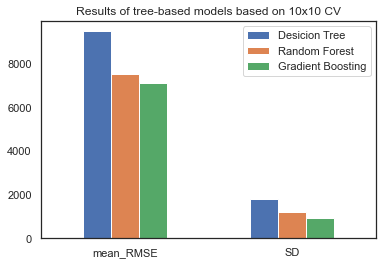

In [44]:
df_results.transpose().plot(kind = 'bar', rot = 0,
                            title = 'Results of tree-based models based on 10x10 CV')

In [45]:
# fit the best model, to infer the most important variables for the prediction
booster_opt.fit(X,y)

GradientBoostingRegressor(learning_rate=0.2, max_depth=2, max_features=5,
                          min_samples_split=20, n_estimators=150)

Text(0.5, 1.0, 'Variable importance of Gradient Boosting Regression')

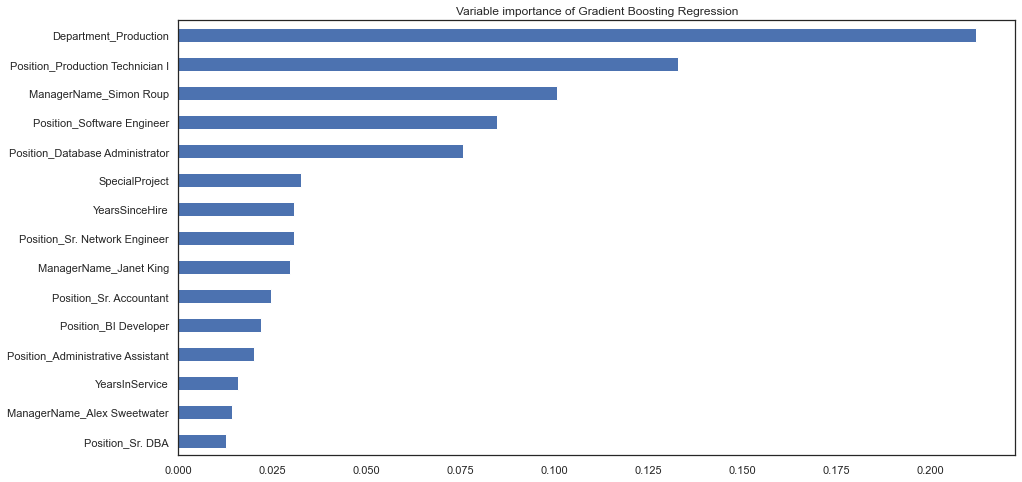

In [46]:
# Plotting the variable importance to see which features influence the model
plt.figure(figsize=(15,8))
imp_1 = pd.Series(booster_opt.feature_importances_, index=X.columns)
imp_1.nlargest(15).sort_values().plot(kind='barh', color='b')
plt.title('Variable importance of Gradient Boosting Regression')

**Conclusion**

1) Gradient Boosting tree seems to be the best and least volatilt method compared to decision tree and random forest

2) The role you fullfill in the organisation seems to have the highest impact on your salary.
The most important variables are based on Position, ManagerName and Department.
Next to that it also matters if you worked on a special project.\